In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import sklearn
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

all_df = pd.read_excel("./TrainDataset2023.xls",index_col=False)


In [64]:
#Remove all rows that have missing values, not inclusive of the first 3 columns, pCR and RFS, so we can still keep the data with missing pCR or RFS results


# Specify the columns to replace values from the 3rd column
columns_to_replace = all_df.columns[2:]

# Replace 999 with NaN in the specified columns
all_df[columns_to_replace] = all_df[columns_to_replace].replace(999, pd.NA)

# Drop rows with missing values in the specified columns
all_df.dropna(subset=columns_to_replace, inplace=True)

#Drop ID column
all_df = all_df.drop('ID', axis=1)

In [65]:
# through eyeballing, identified 13 rows that have values that are too ridiculous, those are: 56, 61, 77, 87, 89,104, 187, 205, 290, 324, 343, 371 389
rows_to_drop = [56, 61, 77, 87, 89, 104, 187, 205, 290, 324, 343, 371, 389]

# Drop the identified rows
all_df_new = all_df.drop(index=rows_to_drop)

In [66]:
# Function to turn extreeme outliers into NaN values
def replace_outliers_with_nan(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    df[column_name] = df[column_name].where((df[column_name] >= lower_bound) & (df[column_name] <= upper_bound), pd.NA)

# Specify the columns to check for outliers (starting from the 14th column)
columns_to_check = all_df.columns[13:]

# Iterate through each specified column and replace outliers with NaN
for column in columns_to_check:
    replace_outliers_with_nan(all_df, column)

# Identify rows with exactly 1 outlier
outliers_count_per_row = all_df[columns_to_check].isna().sum(axis=1)

# Select rows with exactly 1 outlier
rows_with_1_outlier = all_df[outliers_count_per_row == 1]

# Fill null values in rows with exactly 1 outlier with the mean value
mean_values = all_df.mean()
for index, row in rows_with_1_outlier.iterrows():
    for column in columns_to_check:
        if pd.isna(row[column]):
            all_df.at[index, column] = mean_values[column]
            
all_df_new.update(rows_with_1_outlier)

all_df_new.reset_index(drop=True, inplace=True)

In [67]:
#DONE UP TO HERE

#all_df_new.describe()


<AxesSubplot:>

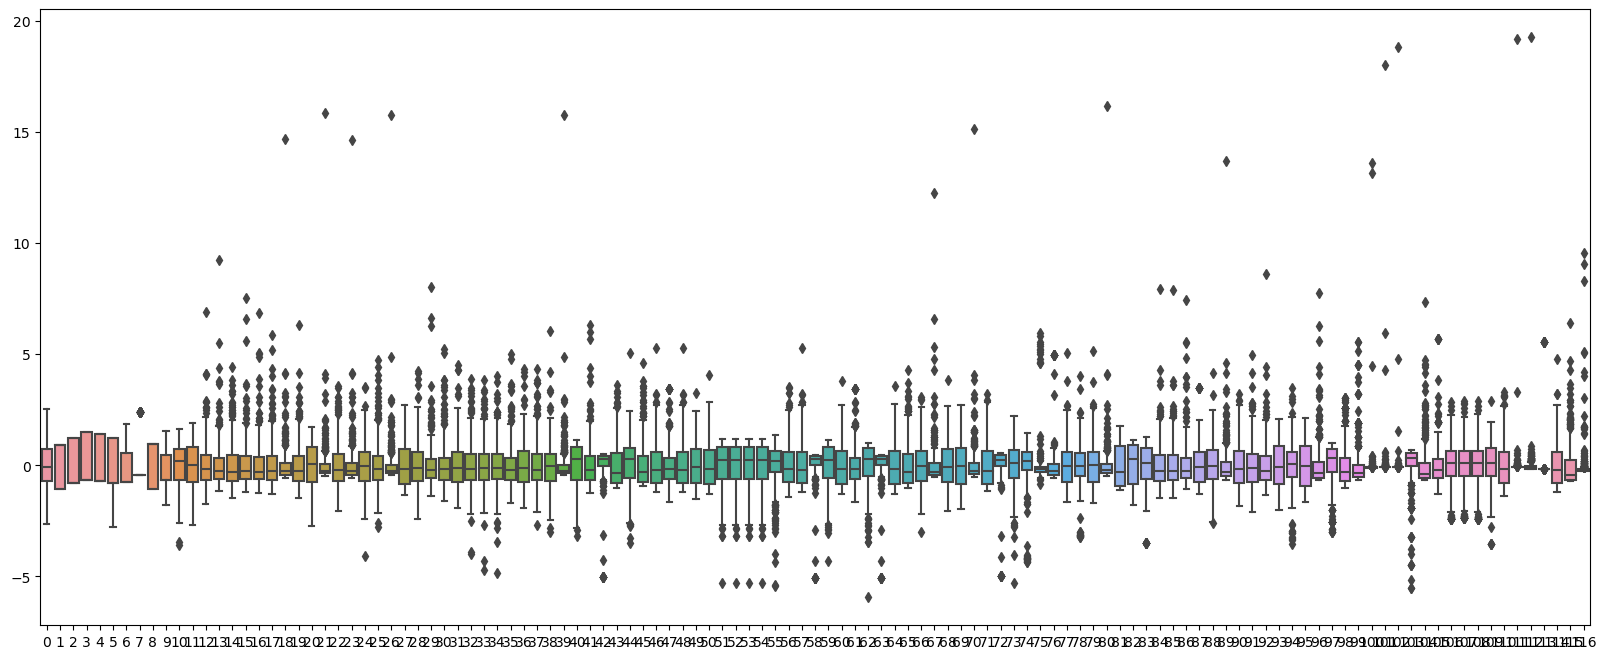

In [68]:

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

X = all_df_new
X = X.drop(columns=['pCR (outcome)','RelapseFreeSurvival (outcome)'],inplace=False) 

Xs = scaler.fit_transform(X) 
fig,ax=plt.subplots(1,figsize=(20,8)) 
sns.boxplot(data=Xs,ax=ax)


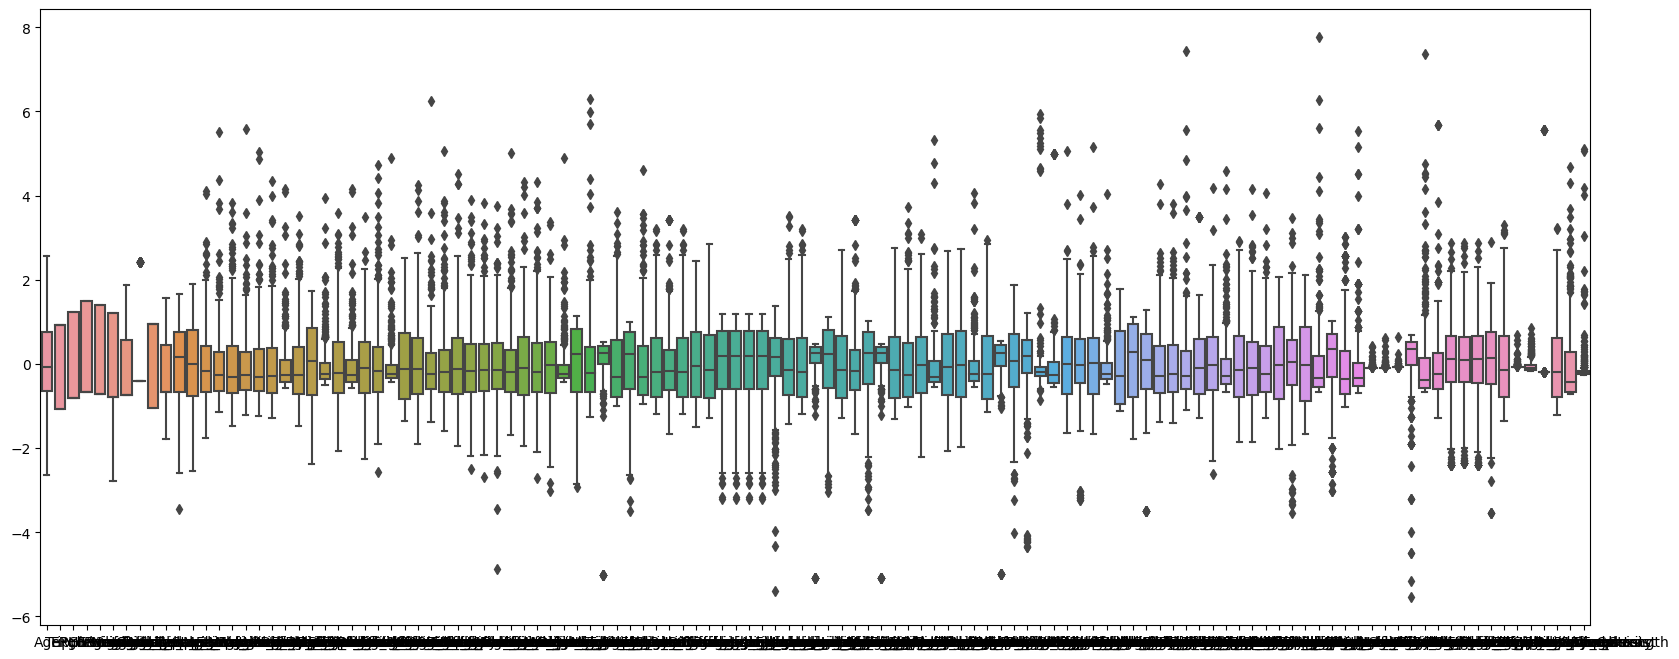

In [69]:
# Function to remove outliers based on set lower and upper bound
def remove_outliers(df, column_name):

    lower_bound = -8
    upper_bound = 8

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    df_no_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df_no_outliers, outliers.index.tolist()

# Give the column names back into Xs_no_outlier
Xs_no_outlier = Xs.copy()
Xs_no_outlier = pd.DataFrame(Xs_no_outlier, columns=X.columns)

# Initialize a list to store dropped row indices
dropped_rows = []

# Loop through each numeric column and remove outliers
for column in Xs_no_outlier.select_dtypes(include='number').columns:
    Xs_no_outlier, outliers_index = remove_outliers(Xs_no_outlier, column)
    dropped_rows.extend(outliers_index)

fig,ax=plt.subplots(1,figsize=(20,8)) 
sns.boxplot(data=Xs_no_outlier,ax=ax)

X_no_outlier = X.copy()
X_no_outlier = X_no_outlier.drop(index = dropped_rows)
#at this point Xs_no_outlier has dropped rows
Y_no_outlier = all_df_new[['pCR (outcome)','RelapseFreeSurvival (outcome)']]
Y_no_outlier = Y_no_outlier.drop(index = dropped_rows)

In [70]:
#FINISH DATA-CLEANING
#FEATURE SELECTION NEXT

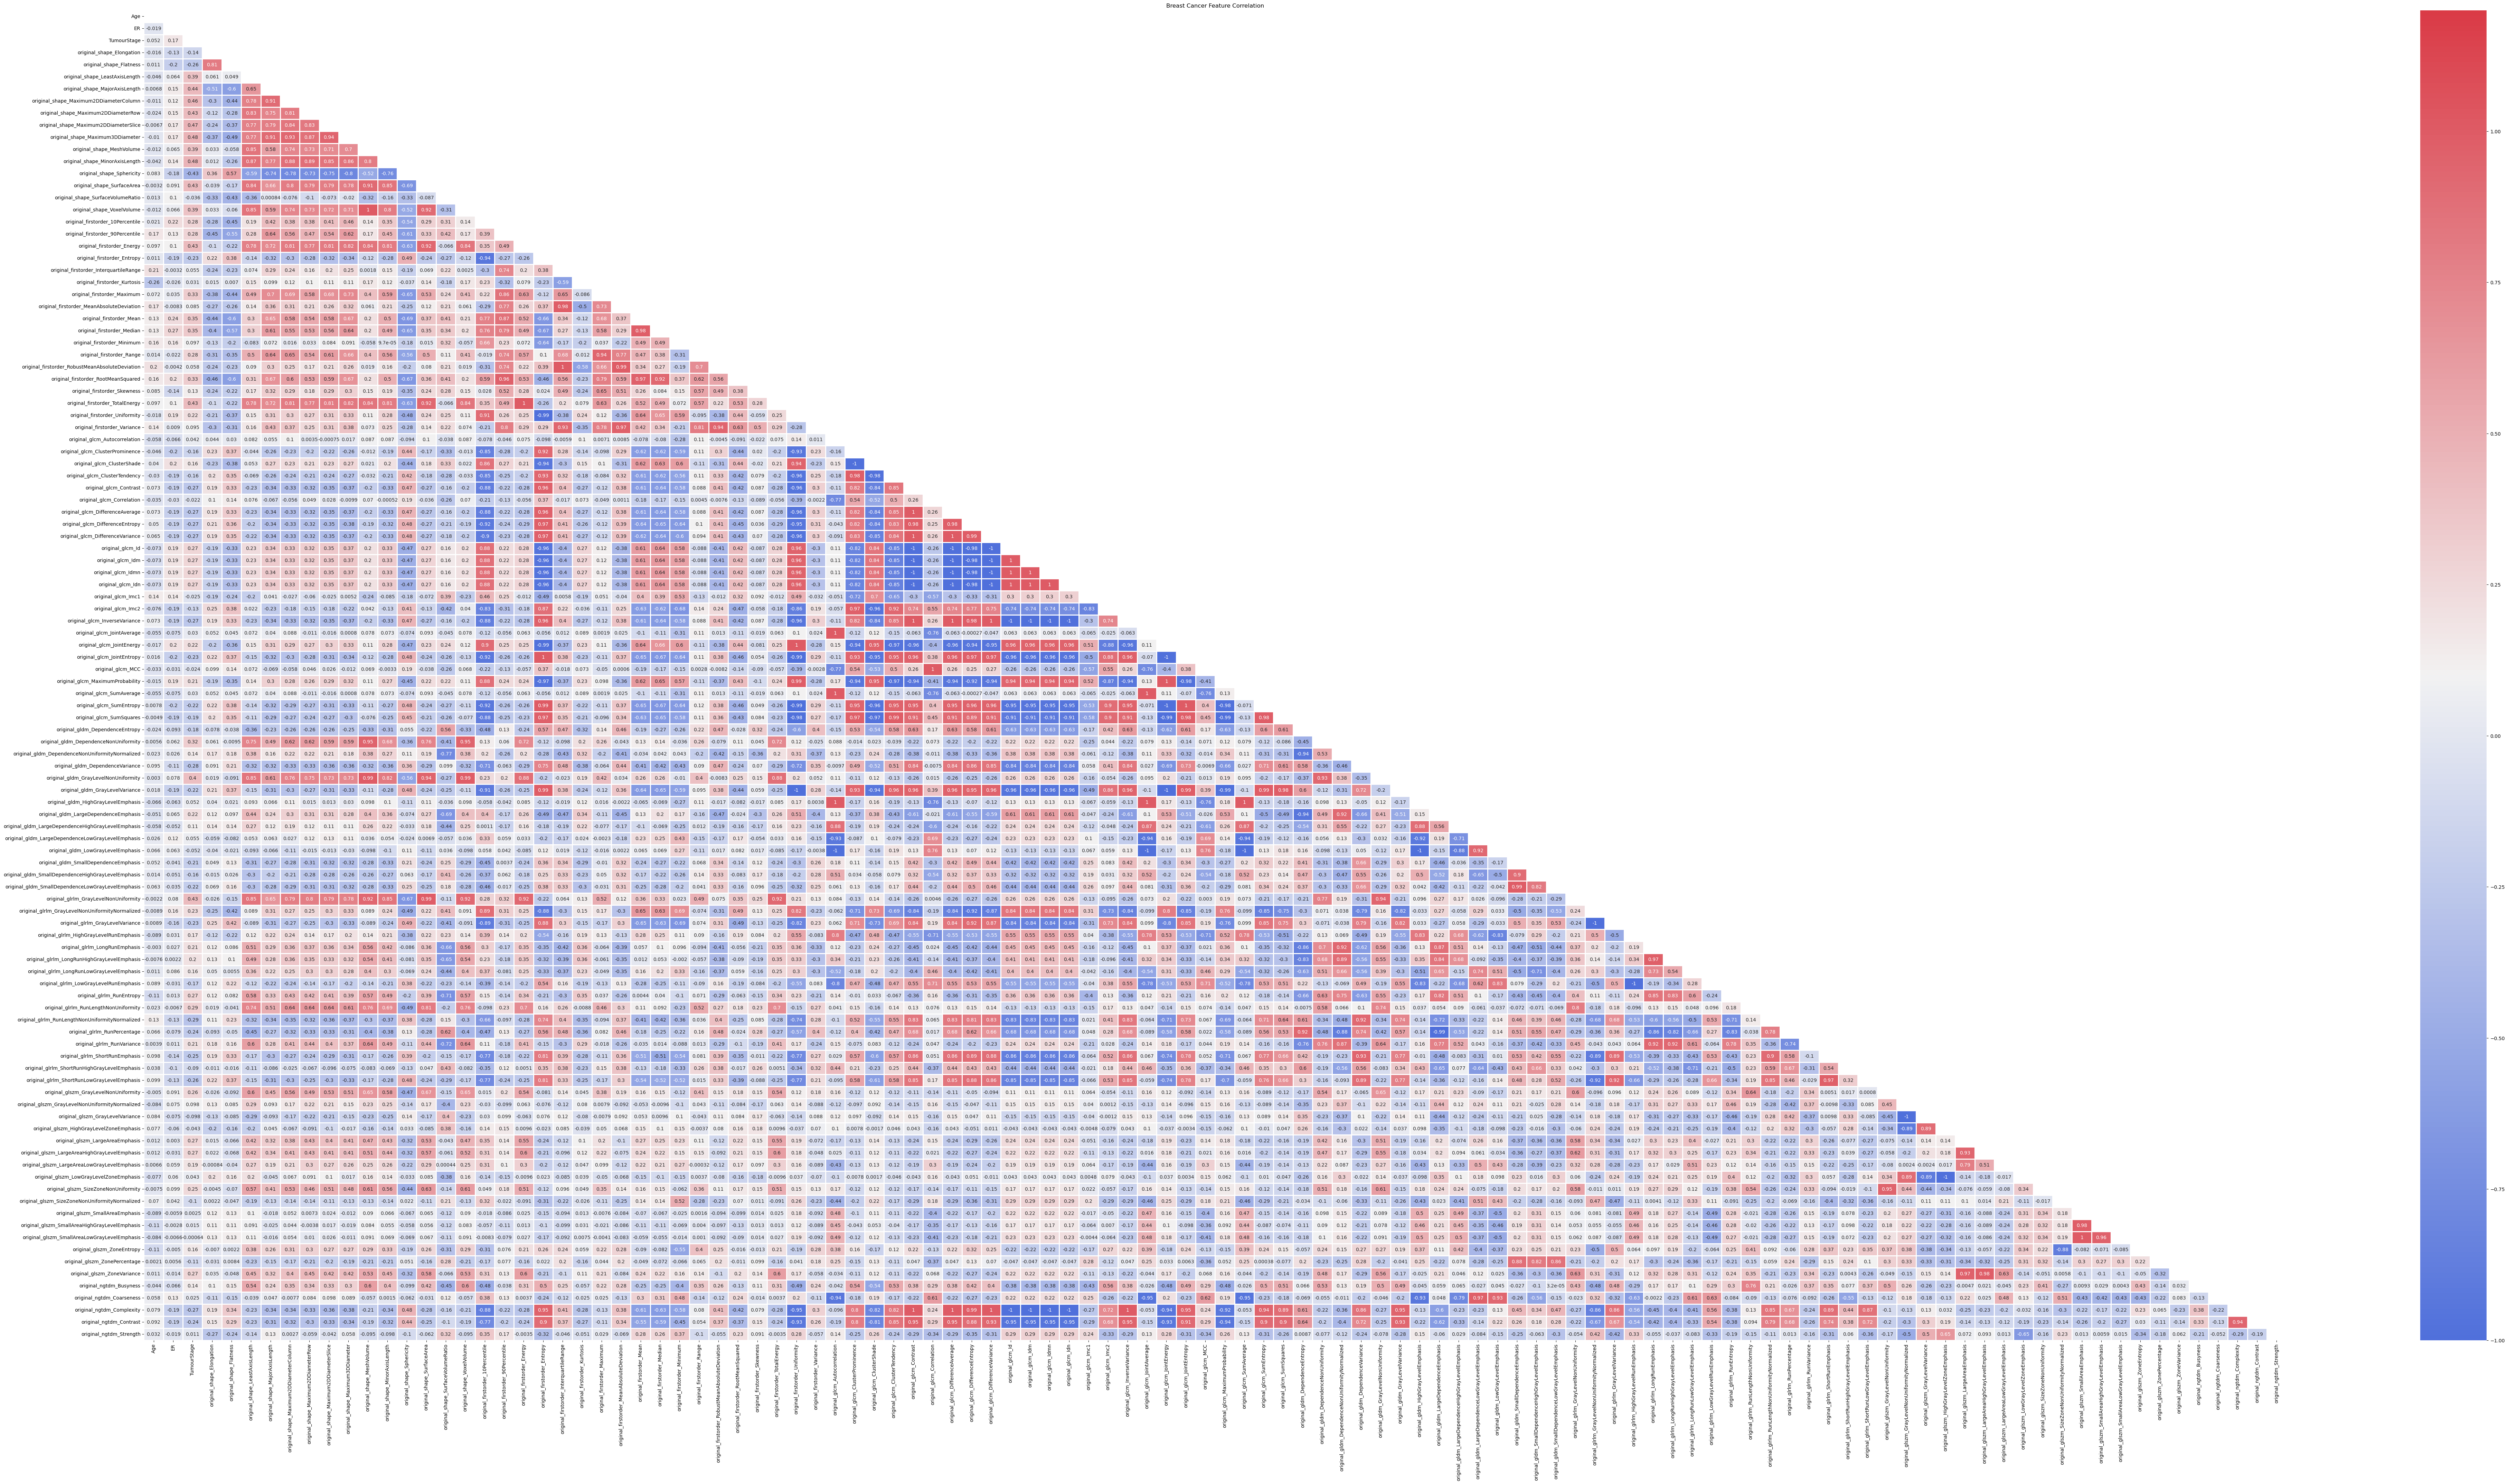

In [71]:
#Compute the correlation matrix to observe the correlations between pairs of features. Check the definition and value range of Pearson correlation.
#definition is the covarience over the standard deviation of both the variables
corrMatt = X_no_outlier.corr()
# Generate a mask for the upper triangle 
mask = np.zeros_like(corrMatt) 
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(100, 50)) 
plt.title('Breast Cancer Feature Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio 
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=1);

In [72]:
threshold = 0.95

# Identify highly correlated features
correlated_features = set()
dropped_features = []  # New list to store dropped features

for i in range(len(corrMatt.columns)):
    for j in range(i + 1, len(corrMatt.columns)):
        if abs(corrMatt.iloc[i, j]) > threshold:
            colname = corrMatt.columns[i]
            correlated_features.add(colname)
            dropped_features.append(colname)  # Add to the list of dropped features

# Drop highly correlated features
X_filtered_corr = X_no_outlier.drop(columns=correlated_features)

# Print or inspect the list of dropped features
#print("Dropped Features:", dropped_features)
X_filtered_corr

Age   ER PgR HER2 TrippleNegative ChemoGrade Proliferation  \
0    41.0  0.0   0    0               1          3             3   
1    39.0  1.0   1    0               0          3             3   
2    31.0  0.0   0    0               1          2             1   
3    35.0  0.0   0    0               1          3             3   
4    61.0  1.0   0    0               0          2             1   
..    ...  ...  ..  ...             ...        ...           ...   
377  58.5  1.0   0    1               0          3             2   
378  34.3  0.0   0    0               1          3             3   
379  53.3  0.0   0    0               1          2             1   
380  68.8  1.0   0    0               0          3             3   
381  46.0  1.0   0    0               0          2             1   

    HistologyType LNStatus  TumourStage  ...  \
0               1        1          2.0  ...   
1               1        1          2.0  ...   
2               1        0          2.0  ...   
3               1        1          3.0  ...   
4               1        0          2.0  ...   
..            ...      ...          ...  ...   
377             1        1          4.0  ...   
378             1        0          2.0  ...   
379             1        0          2.0  ...   
380             1        1          3.0  ...   
381             1        1          2.0  ...   

     original_glszm_SizeZoneNonUniformityNormalized  \
0                                          0.180900   
1                                          0.198125   
2                                          0.275749   
3                                          0.253014   
4                                          0.216409   
..                                              ...   
377                                        0.245562   
378                                        0.191327   
379                                        0.375000   
380                                        0.117778   
381                                        0.423868   

     original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
0                                        0.375126                    3.325332   
1                                        0.444391                    3.032144   
2                                        0.534549                    2.485848   
3                                        0.506185                    2.606255   
4                                        0.462282                    2.809279   
..                                            ...                         ...   
377                                      0.476493                    2.453583   
378                                      0.418382                    2.995603   
379                                      0.527778                    1.500000   
380                                      0.313693                    3.573557   
381                                      0.670229                    1.857045   

     original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                         0.002314                 3.880772e+06   
1                         0.005612                 2.372010e+06   
2                         0.006752                 1.540027e+06   
3                         0.003755                 6.936741e+06   
4                         0.006521                 1.265399e+06   
..                             ...                          ...   
377                       0.003229                 2.327038e+06   
378                       0.004243                 1.005061e+06   
379                       0.003728                 2.132007e+05   
380                       0.001112                 2.008034e+07   
381                       0.006706                 5.609262e+05   

     original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                 473.464852                   0.000768   
1                  59.459710                   0.004383

In [73]:
#Y_no_outlier = all_df_new[['pCR (outcome)','RelapseFreeSurvival (outcome)']]
#Y_no_outlier = Y_no_outlier.drop(index = dropped_rows)
#Y.reset_index(drop=True, inplace=True)
#X = all_df_new.drop(columns=['pCR (outcome)','RelapseFreeSurvival (outcome)'],inplace=False) 
#X = X.drop(index = dropped_rows)
#X.reset_index(drop=True, inplace=True)

Y_classification = Y_no_outlier['pCR (outcome)']
Y_classification = Y_classification.replace(999, pd.NA)
indices_to_drop = Y_classification[Y_classification.isna()].index
Y_classification.drop(indices_to_drop, inplace=True)

X_classification = X_filtered_corr.copy()
X_classification.drop(indices_to_drop, inplace=True)

Y_regression = Y_no_outlier['RelapseFreeSurvival (outcome)']
X_regression = X_filtered_corr.copy()

#classification_combined_df = pd.concat([Y_classification, Xs_no_outlier], axis=1)
#regression_combined_df = pd.concat([Y_regression, Xs_no_outlier], axis=1)

In [74]:
#FINISH CORRELATION MATRIX
#NOW CHECK FOR CHI SQUARE FOR CLASSIFICATION

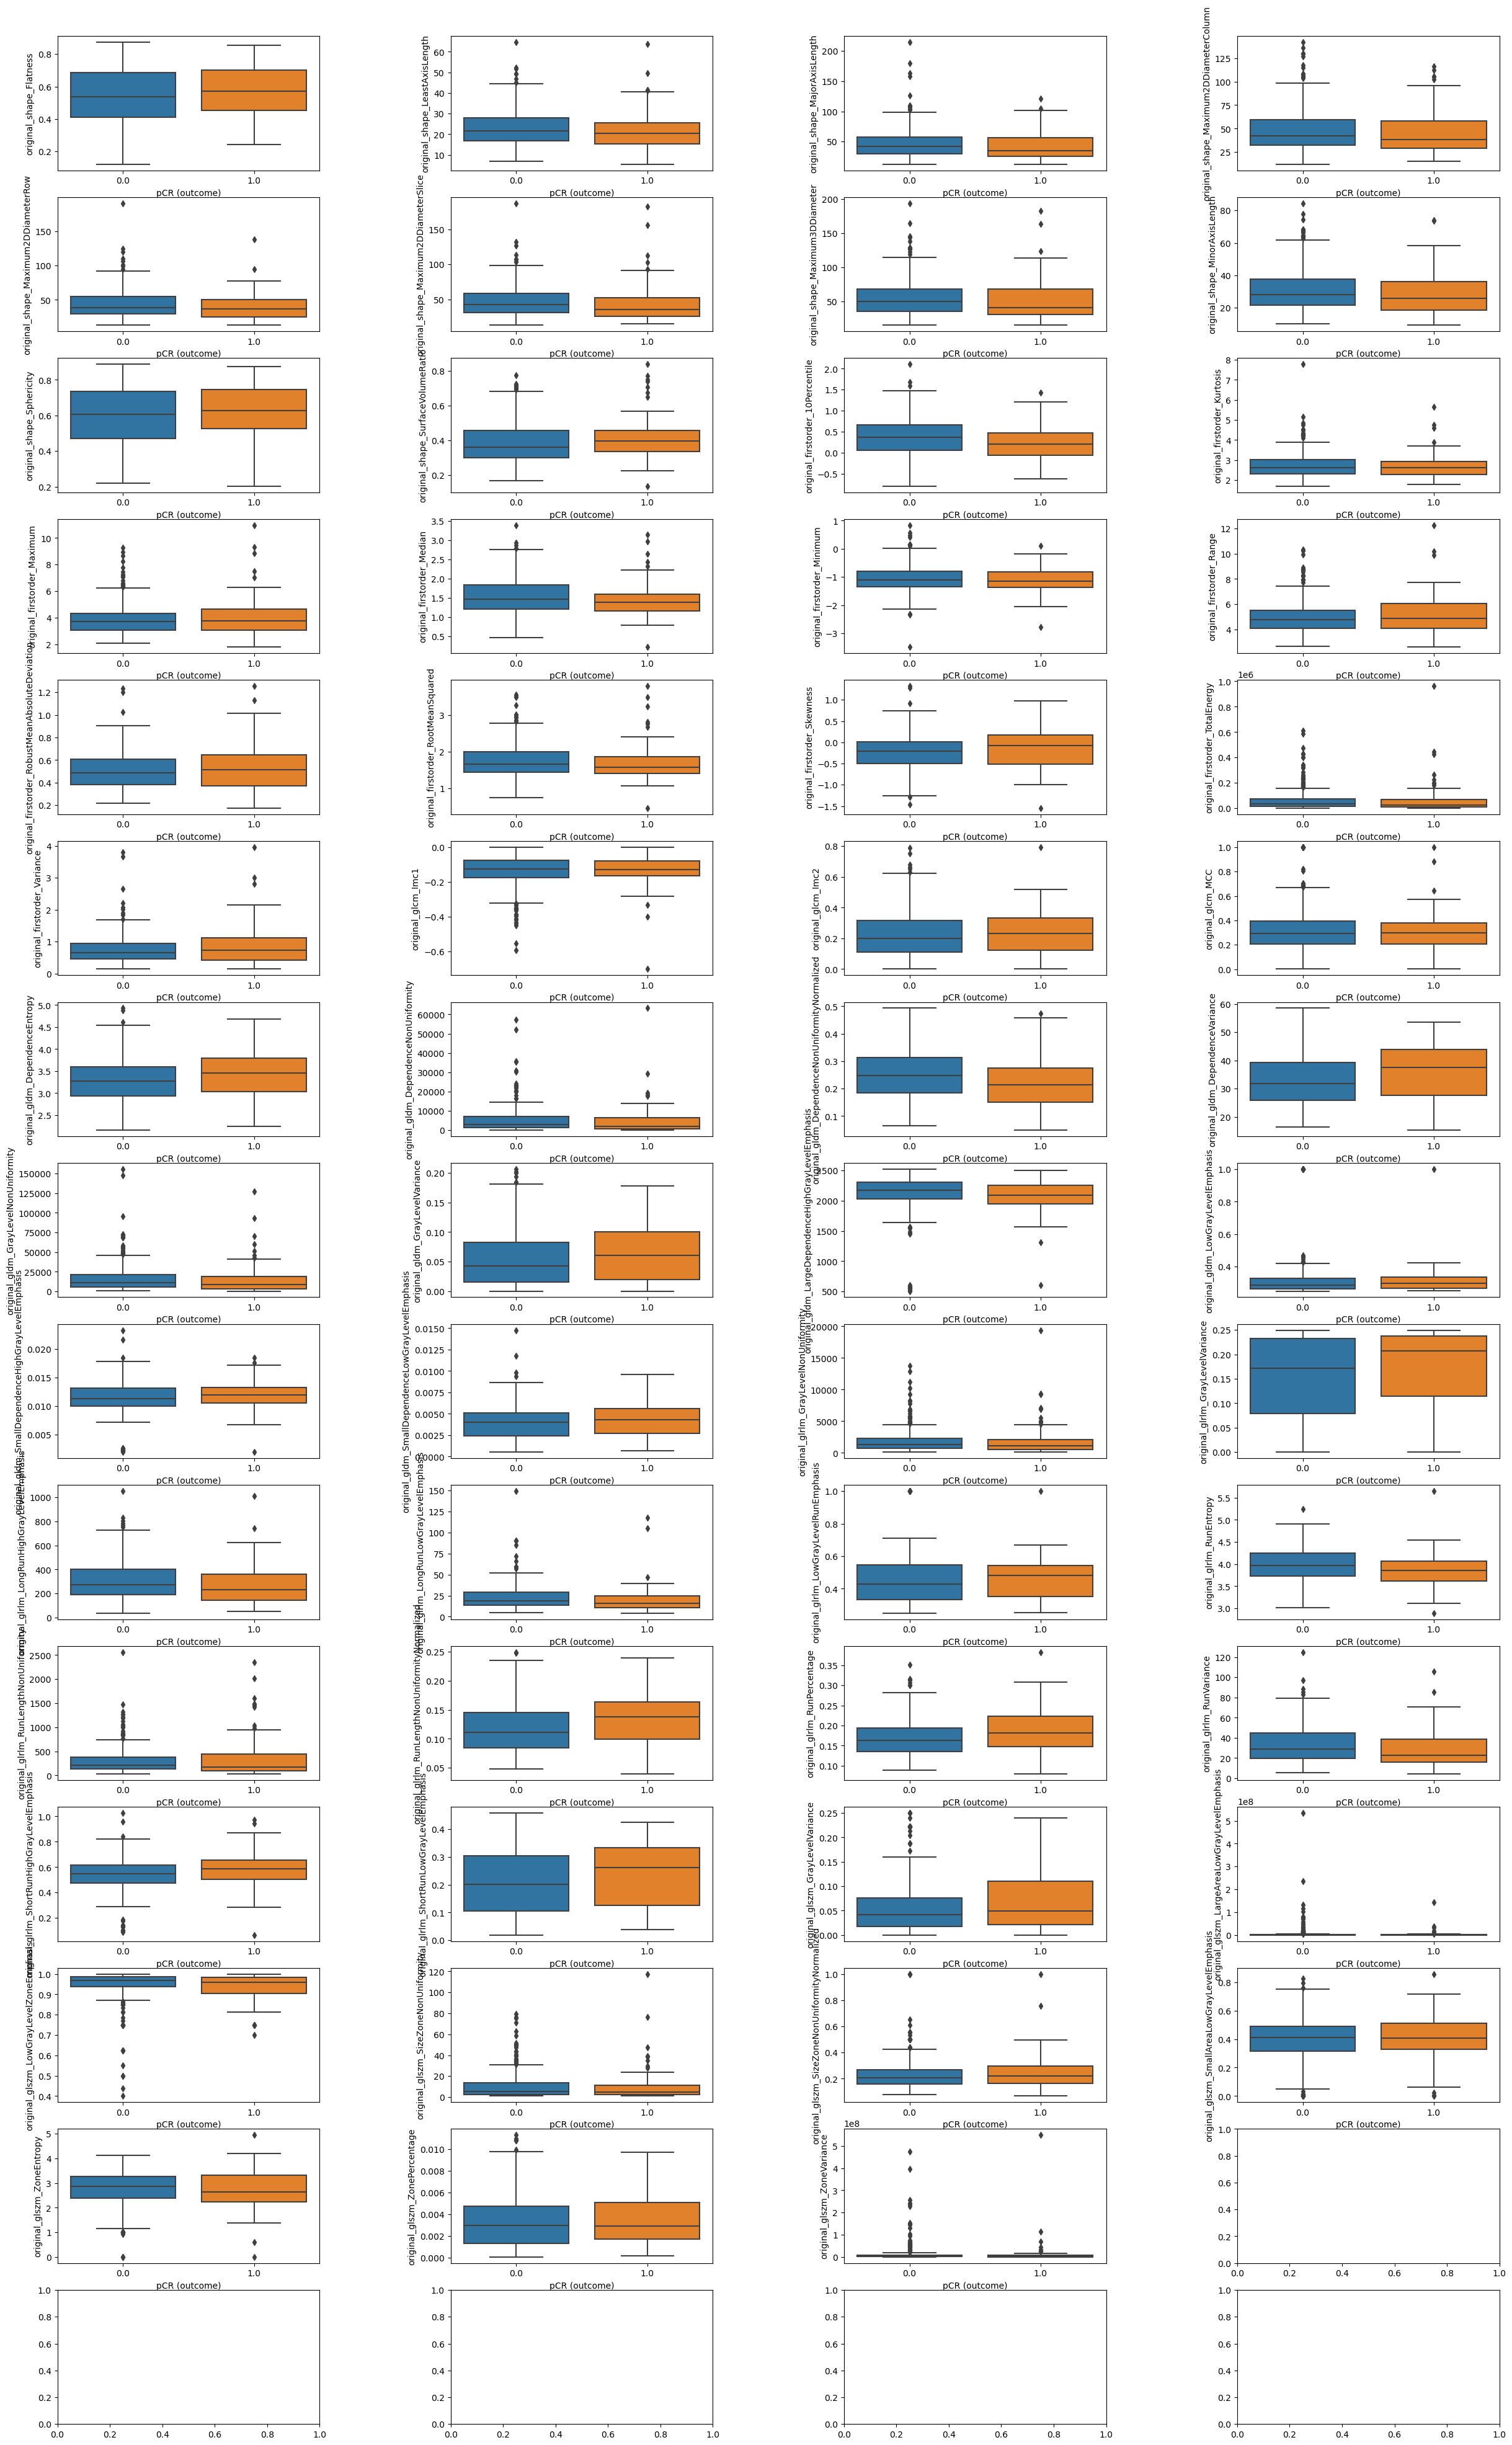

In [82]:
#Use boxplots to see if certain feature can discriminate between pcr outcomes

fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(30,50)) 

fig.subplots_adjust(hspace =.2, wspace=.5)
axes = axes.ravel()
for i, col in enumerate(X_classification.columns[5:60]):
    _= sns.boxplot(y=col, x=Y_classification, data=X_classification, ax=axes[i])

#visually, it is difficult to see what features are useful, unable to make a descision on 
#what continuous features to drop.

           Feature  Chi2 Score   P-value
0              Age    0.150945  0.697634
1               ER    8.359891  0.003836
2              PgR    8.352733  0.003851
3             HER2   10.871189  0.000977
4  TrippleNegative    1.881975  0.170110
5       ChemoGrade    0.149830  0.698697
6    Proliferation    1.733156  0.188008
7    HistologyType    0.168435  0.681506
8         LNStatus    3.942257  0.047088
9      TumourStage    1.098713  0.294549


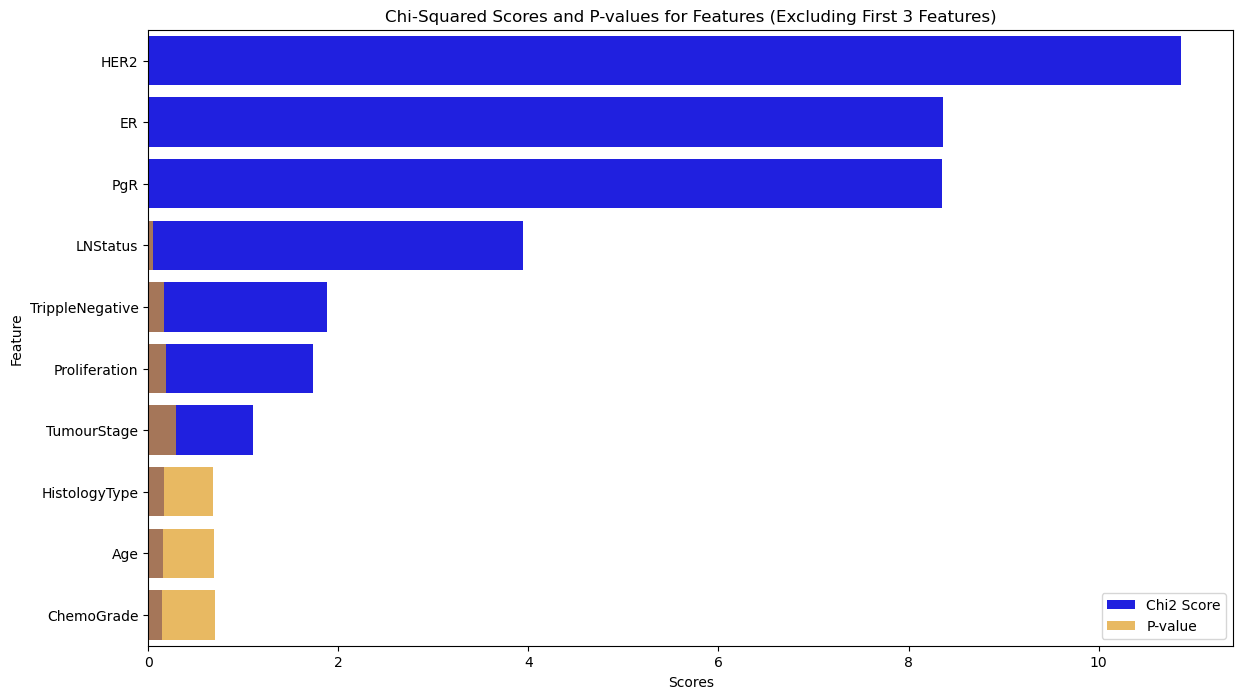

In [76]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


X_classification_chi = X_classification.iloc[:, :10]
Y_classification = pd.to_numeric(Y_classification, errors='coerce')

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_chi2 = selector.fit_transform(X_classification_chi, Y_classification)

# Get selected features and their scores
selected_features = X_classification_chi.columns[selector.get_support()]
chi2_scores = selector.scores_
p_values = selector.pvalues_


# Create a DataFrame to inspect the results
results_df = pd.DataFrame({
    'Feature': selected_features,
    'Chi2 Score': chi2_scores,
    'P-value': p_values
})

# Display the DataFrame
print(results_df)

# Sort the results_df based on 'Chi2 Score'
results_df_sorted = results_df.sort_values(by='Chi2 Score', ascending=False)

#visualized_results_df_sorted = results_df_sorted[~results_df_sorted['Feature']]

# Plotting the modified DataFrame with p-values
plt.figure(figsize=(14, 8))
sns.barplot(x='Chi2 Score', y='Feature', data=results_df_sorted, label='Chi2 Score', color='blue')
sns.barplot(x='P-value', y='Feature', data=results_df_sorted, label='P-value', color='orange', alpha=0.7)

plt.title('Chi-Squared Scores and P-values for Features (Excluding First 3 Features)')
plt.xlabel('Scores')
plt.ylabel('Feature')
plt.legend()
plt.show()

#features like ER, PgR, HER2, and LNStatus appear to have stronger associations with the
#target variable compared to other features. 

#Features with p-values greater than 0.05 (not significant) 
#do not provide enough evidence to reject the null hypothesis of no 
#association with the target variable at the chosen significance level. Therefore, based 
#on a significance level of 0.05, we dropped the following features:
#Age
#TrippleNegative
#ChemoGrade
#Proliferation
#HistologyType
#TumourStage

selected_features_to_drop = ['Age', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'TumourStage']
X_classification = X_classification.drop(columns=selected_features_to_drop)


In [77]:
#FINISH CHI SQUARE FOR CLASSIFICATION
#NOW CHECK FOR ANOVA FOR REGRESSION

In [78]:
import statsmodels.api as sm

# Assuming 'X_regression_anova' is your independent variable matrix and 'Y_regression' is the dependent variable
# Replace 'X_regression_anova' and 'Y_regression' with your actual variable names

X_regression_anova = X_regression.iloc[:, :10]

categorical_columns = ['Age', 'ER','TumourStage', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus']
X_regression_anova[categorical_columns] = X_regression_anova[categorical_columns].astype('category')

# Add a constant term to the independent variable matrix for the intercept
X_with_intercept = sm.add_constant(X_regression_anova)

# Fit the OLS (Ordinary Least Squares) regression model
model_full = sm.OLS(Y_regression, X_with_intercept).fit()

# Fit a reduced model (without some predictors)
model_reduced = sm.OLS(Y_regression, X_regression_anova).fit()

# Perform ANOVA manually by comparing the two models
anova_results = sm.stats.anova_lm(model_reduced, model_full)

# Display the ANOVA table
print(anova_results)

#The F-statistic is 38.30, and the p-value (Pr(>F)) is very close to zero (1.641057e-09), 
#indicating that the full model is statistically significantly better than the reduced model. 
#Therefore, it suggests that the variable(s) omitted in the reduced model contribute significantly 
#to explaining the variance in the dependent variable.


   df_resid            ssr  df_diff       ss_diff          F        Pr(>F)
0     363.0  296442.013100      0.0           NaN        NaN           NaN
1     362.0  268077.009082      1.0  28365.004018  38.302917  1.641057e-09
